## Import Libraries

In [1]:
import pennylane as qml
# from pennylane import numpy as np

import numpy as np
np.bool8 = np.bool_

import gym
import collections
import random

import torch
import matplotlib.pyplot as plt
import torch.optim as optim

from datetime import datetime
import os
from torch.utils.tensorboard import SummaryWriter


now     = datetime.now()
f_dir = f'tensorboard/QRL/Cartpole/QRL_DQN_nlayer_3_{now.date()}_{now.hour}h_{now.minute}m_{now.second}s/{now.date()}_{now.hour}h_{now.minute}m_{now.second}s'
os.makedirs(f_dir, exist_ok=True)
writer = SummaryWriter(f_dir)

## Hyperparameter Settings

In [2]:
#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32

## Replay Buffer

In [3]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

## Neural Network Architecture

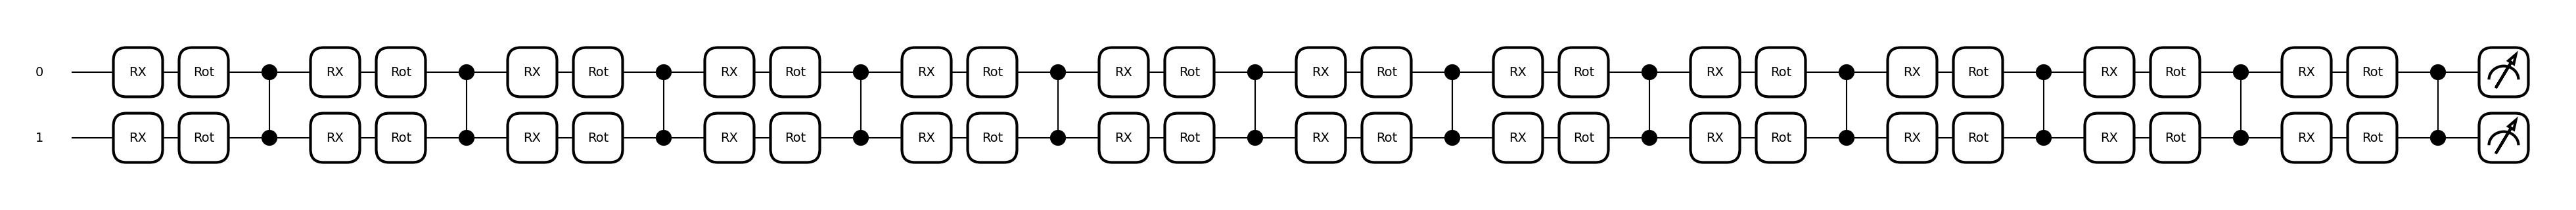

In [4]:
# n_qubits = 1
# dev_1 = qml.device("default.qubit", wires=n_qubits)

# # qnode 함수는 무조건 inputs, weights를 인자로 가져야 함 -> 아니면 오류
# @qml.qnode(dev_1)
# def qnode(inputs, weights):
#     for p in weights:
#         for i, param in enumerate(p):
#             qml.RX(inputs[:, i], wires=0)           
#             qml.Rot(*param, wires=0)               # 그에 상응하는 Rot gate
#     return qml.expval(qml.Z(wires=0))

dev_2 = qml.device("default.qubit", wires=2)
@qml.qnode(dev_2)
def qnode_2(inputs, weights):
    '''여기서는 input이 (layer, x_dim, qubit, 3) '''
    for p in weights:
        # inner-wire setup
        for i, param in enumerate(p):
            for j, qubit_param in enumerate(param):
                qml.RX(inputs[:, i], wires=j)           
                qml.Rot(*qubit_param, wires=j)
            # inter-wire setup
            qml.CZ(wires=[0, 1])
    return [qml.expval(qml.Z(wires=i)) for i in range(2)]
    
# model parameters
n_layers = 3
x_dim = 4
n_param_per_gate = 3
weight_shapes = {"weights": (n_layers, x_dim, 2, n_param_per_gate)}
# model = qml.qnn.TorchLayer(qnode, weight_shapes)
qml.draw_mpl(qnode_2)(np.zeros((1, 4, 2, 3)), np.zeros((n_layers, x_dim, 2, n_param_per_gate)))
plt.show()
#(1 ,4, 2, 3) -> (batch_size(dumdummy), x_dim, num_qubit, n_param_per_gate)

In [5]:
def create_model(n_qubit, n_layer, x_dim):
    weight_shapes = {"weights": (n_layer, x_dim, n_qubit, 3)}
    return qml.qnn.TorchLayer(qnode, weight_shapes)

In [6]:
def sample_action(act, epsilon):
    coin = random.random()
    if coin < epsilon:
        return random.randint(0,1)
    else : 
        return act.argmax().item()

In [7]:
import torch.nn.functional as F

def train(q, q_target, memory, optimizer):
    for i in range(10):
        s, a, r, s_prime, done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

## Driving Code

In [ ]:
# model parameters
n_layers = 3
x_dim = 4
n_param_per_gate = 3
weight_shapes = {"weights": (n_layers, x_dim, 2, n_param_per_gate)}

env = gym.make('CartPole-v1')
# env = gym.make('CartPole-v1', render_mode='human')
q = qml.qnn.TorchLayer(qnode_2, weight_shapes).to("cuda")
q_target = qml.qnn.TorchLayer(qnode_2, weight_shapes).to("cuda")
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()


# best_return = -1e9
print_interval = 20
score = 0.0  
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

for n_epi in range(10000):
    epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
    s, _ = env.reset()
    done = False

    while not done:
        env.render()
        a = q(torch.tensor(s).float().view(1, -1))
        a = sample_action(a, epsilon)      
        s_prime, r, done, truncated, info = env.step(a)

        # 지금 QNN output을 그냥 ~1에서 1 사이로 해 줘서
        # 이걸 one-hot vector로 바꿔줘야 할듯

        done_mask = 0.0 if done else 1.0
        memory.put((s,a,r/100.0,s_prime, done_mask))
        s = s_prime

        score += r
        
        if done:
            break

        # If episode reward exceeds 500, end episode
        if score > 499:
            print('over 500')
            break


    if memory.size()>2000:
        train(q, q_target, memory, optimizer)

    if n_epi%print_interval==0 and n_epi!=0:
        q_target.load_state_dict(q.state_dict())
        # print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
        #                                         n_epi, score/print_interval, memory.size(), epsilon*100))

        
    print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                    n_epi, score, memory.size(), epsilon*100))
    writer.add_scalar('Reward', score, n_epi)
    score = 0.0


env.close()


c:\Users\GSKIM\anaconda3\Lib\site-packages\gym\envs\classic_control\cartpole.py:211: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


n_episode :0, score : 19.0, n_buffer : 19, eps : 8.0%
n_episode :1, score : 29.0, n_buffer : 48, eps : 8.0%
n_episode :2, score : 34.0, n_buffer : 82, eps : 8.0%
n_episode :3, score : 27.0, n_buffer : 109, eps : 8.0%
n_episode :4, score : 25.0, n_buffer : 134, eps : 8.0%
n_episode :5, score : 24.0, n_buffer : 158, eps : 8.0%
n_episode :6, score : 28.0, n_buffer : 186, eps : 8.0%
n_episode :7, score : 19.0, n_buffer : 205, eps : 8.0%
n_episode :8, score : 38.0, n_buffer : 243, eps : 8.0%
n_episode :9, score : 20.0, n_buffer : 263, eps : 8.0%
n_episode :10, score : 32.0, n_buffer : 295, eps : 8.0%
n_episode :11, score : 19.0, n_buffer : 314, eps : 7.9%
n_episode :12, score : 23.0, n_buffer : 337, eps : 7.9%
n_episode :13, score : 34.0, n_buffer : 371, eps : 7.9%
n_episode :14, score : 16.0, n_buffer : 387, eps : 7.9%
n_episode :15, score : 33.0, n_buffer : 420, eps : 7.9%
n_episode :16, score : 27.0, n_buffer : 447, eps : 7.9%
n_episode :17, score : 18.0, n_buffer : 465, eps : 7.9%
n_epi

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_29728\848517094.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \


n_episode :77, score : 26.0, n_buffer : 2001, eps : 7.6%
n_episode :78, score : 25.0, n_buffer : 2026, eps : 7.6%
n_episode :79, score : 29.0, n_buffer : 2055, eps : 7.6%
n_episode :80, score : 22.0, n_buffer : 2077, eps : 7.6%
n_episode :81, score : 21.0, n_buffer : 2098, eps : 7.6%
n_episode :82, score : 24.0, n_buffer : 2122, eps : 7.6%
n_episode :83, score : 19.0, n_buffer : 2141, eps : 7.6%
n_episode :84, score : 19.0, n_buffer : 2160, eps : 7.6%
n_episode :85, score : 24.0, n_buffer : 2184, eps : 7.6%
n_episode :86, score : 24.0, n_buffer : 2208, eps : 7.6%
n_episode :87, score : 19.0, n_buffer : 2227, eps : 7.6%
n_episode :88, score : 25.0, n_buffer : 2252, eps : 7.6%
n_episode :89, score : 26.0, n_buffer : 2278, eps : 7.6%
n_episode :90, score : 23.0, n_buffer : 2301, eps : 7.5%
n_episode :91, score : 30.0, n_buffer : 2331, eps : 7.5%
n_episode :92, score : 23.0, n_buffer : 2354, eps : 7.5%
n_episode :93, score : 26.0, n_buffer : 2380, eps : 7.5%
n_episode :94, score : 23.0, n_

qiskit으로 그린 해당 Quantum Circuit

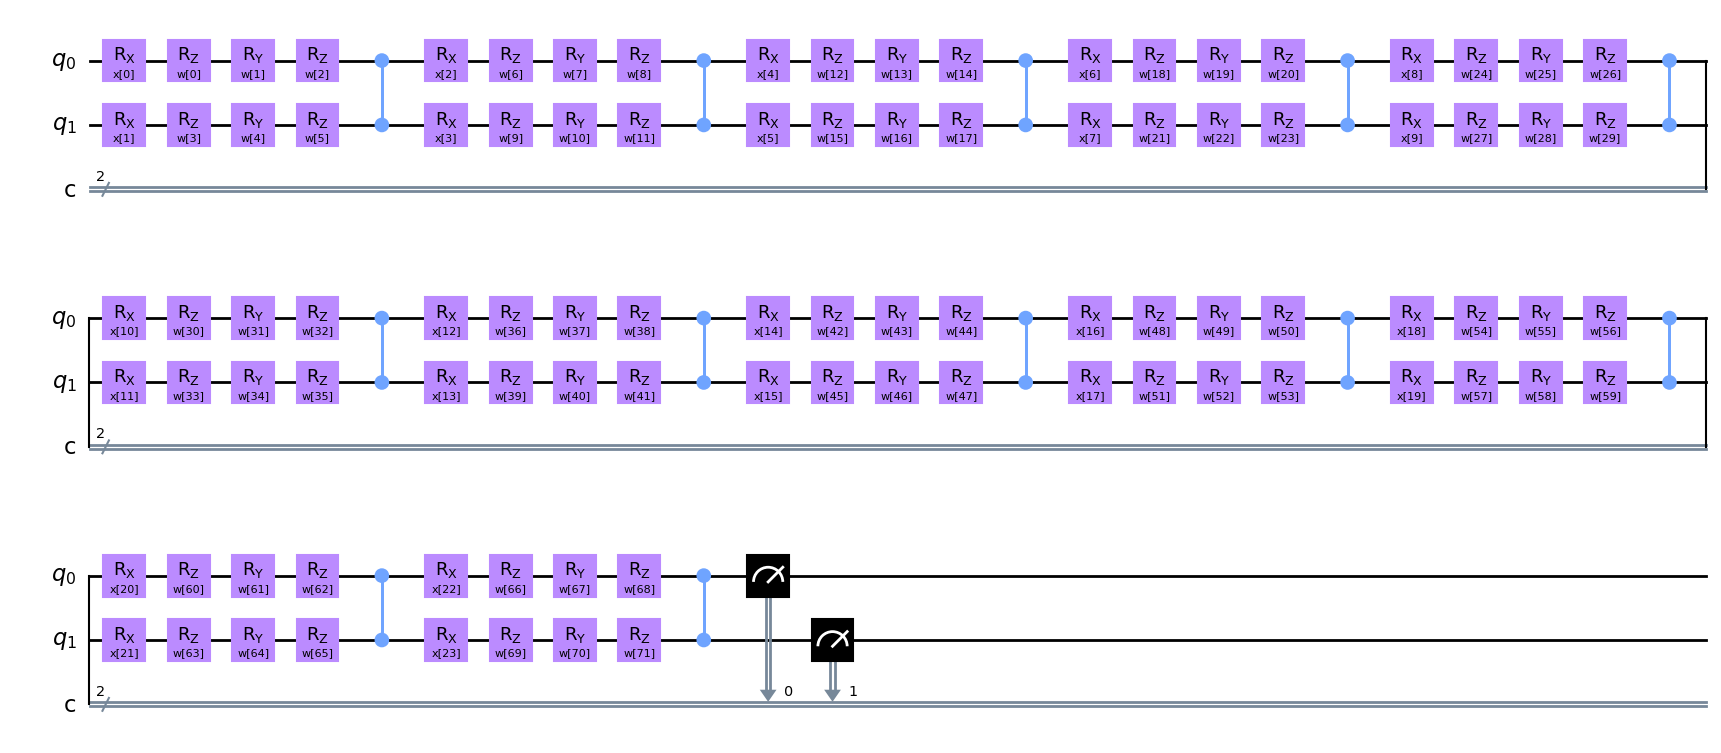